In [1]:
from glob import glob

paths_json = glob('/home/yuki/Work/Tohoku/Datasets/CMMD/*/*.Json')
paths_json = sorted(paths_json)

(2294, 2294)


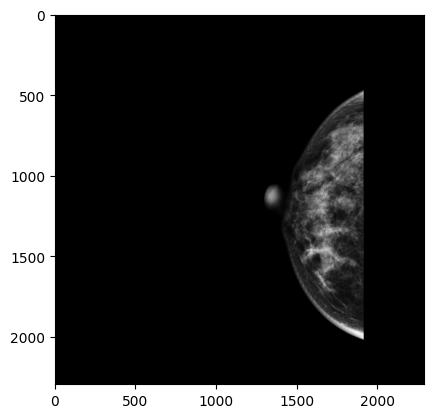

In [2]:
import pydicom
from PIL import Image
import matplotlib.pyplot as plt

path_dcm = '/home/yuki/Work/Tohoku/Datasets/CMMD/D1-0903/DicomFile.dcm'

def show_dcm(path_dcm):
    dataset = pydicom.filereader.dcmread(path_dcm)
    img = dataset.pixel_array
    print(img.shape)

    pil_img = Image.fromarray(img)
    pil_img = pil_img.convert('L')
    plt.imshow(pil_img, cmap = 'gray')
    plt.show()
    plt.close()
  
show_dcm(path_dcm)

## jpgファイルに変換し保存

In [3]:
import os
from pathlib import Path
from tqdm import tqdm

for j in tqdm(paths_json):
    fname = Path(j).parent.stem
    path_dcm = os.path.join('/home/yuki/Work/Tohoku/Datasets/CMMD', fname, 'DicomFile.dcm')
    
    dataset = pydicom.filereader.dcmread(path_dcm)
    img = dataset.pixel_array

    pil_img = Image.fromarray(img)
    pil_img = pil_img.convert('L')
    
    savename = os.path.join(Path(path_dcm).parent, f'{Path(path_dcm).parent.stem}.jpg')
    pil_img.save(savename)
    
    # show_dcm(path_dcm)

100%|██████████| 1195/1195 [00:23<00:00, 50.08it/s]


## jsonファイルがあるフォルダをピックアップ

In [4]:
import json

paths_json_have_label = []
for j in paths_json:
    with open(j) as f:
        txt = f.read()
    if len(txt) > 0:
        with open(j) as f:
            file = json.load(f)
        stem = Path(j).parent.stem
        path_json = os.path.join(stem, 'AnnotationFile.Json')
        path_dcm = os.path.join(stem, 'DicomFile.dcm')
        # print(path_json, path_dcm)
        paths_json_have_label.append(path_json)

In [5]:
len(paths_json_have_label)

395

In [6]:
for j in paths_json_have_label:
    path = os.path.join('/home/yuki/Work/Tohoku/Datasets/CMMD', j)
    with open(path) as f:
        file = json.load(f)
    
    for f in file:
        print(f['label'])
    break

calc 


In [7]:
import numpy as np

px, py = [], []
for p in file[0]['cgPoints']:
    px.append(p['x'])
    py.append(p['y'])
    
[np.min(px), np.min(py), np.max(px), np.max(py)]

[1589.6945510364724, 1356.922900007618, 1686.801742876731, 1532.5726734833797]

## train, valに分ける

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

idx_all = np.arange(len(paths_json_have_label))

DIR = "/home/yuki/Work/Tohoku/Datasets/CMMD"
dict_class = {'mass': 0, 'calc': 1, 'TC': 2, 'FA': 3,
              'dist': 4, 'FAD': 5, 'cyst': 6, 'lipoma': 7}

labels_all = []
count = 0
for idx in idx_all:
    path = os.path.join(DIR, paths_json_have_label[idx])
    with open(path) as f:
        file = json.load(f)
        
    labels = []
    if len(file) > 0:
        for f in file:
            label = f['label'].replace(' ', '')
            labels.append(label)
            break
    else:
        labels.append('')
    labels_all.append(labels)
    
idx_train, idx_val = train_test_split(idx_all,
                                      stratify=labels_all,
                                      test_size=0.2,
                                      random_state=0)


## ラベルの分布をチェック

In [9]:
DIR = "/home/yuki/Work/Tohoku/Datasets/CMMD"

labels_train = []
for idx in idx_train:
    path = os.path.join(DIR, paths_json_have_label[idx])
    with open(path) as f:
        file = json.load(f)
    for f in file:
        labels_train.append(f['label'].replace(' ', ''))
        
labels_val = []
for idx in idx_val:
    path = os.path.join(DIR, paths_json_have_label[idx])
    with open(path) as f:
        file = json.load(f)
    for f in file:
        labels_val.append(f['label'].replace(' ', ''))


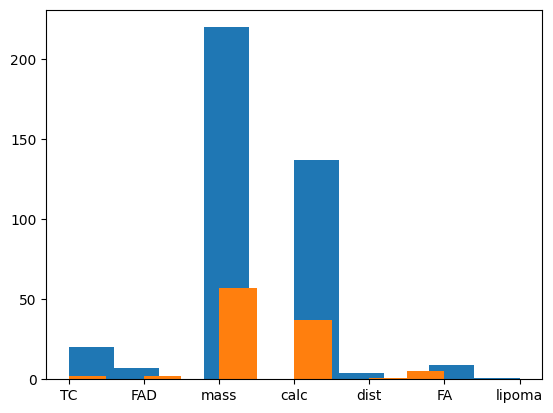

In [10]:
plt.hist(labels_train);
plt.hist(labels_val);


## coco形式に保存し直す

In [11]:
import shutil

DIR_FROM = "/home/yuki/Work/Tohoku/Datasets/CMMD"
DIR_TO = "/home/yuki/Work/Tohoku/Datasets/CMMD_COCOformat"

# 画像
for idx in tqdm(idx_train):
    name = Path(paths_json_have_label[idx]).parent
    path_from = os.path.join(DIR_FROM, name, f'{name}.jpg')
    path_to = os.path.join(DIR_TO, f'train/images/{name}.jpg')
    shutil.copy(path_from, path_to)
    
for idx in tqdm(idx_val):
    name = Path(paths_json_have_label[idx]).parent
    path_from = os.path.join(DIR_FROM, name, f'{name}.jpg')
    path_to = os.path.join(DIR_TO, f'val/images/{name}.jpg')
    shutil.copy(path_from, path_to)

100%|██████████| 79/79 [00:00<00:00, 3237.07it/s]


In [12]:
# annotation
import cv2

dict_class = {'mass': 0, 'calc': 1, 'TC': 2, 'FA': 3,
              'dist': 4, 'FAD': 5, 'cyst': 6, 'lipoma': 7}


def get_cmmd_dict(img_dir, paths_json):
    paths_json = [os.path.join(img_dir, p) for p in paths_json]

    jsons = []
    imgs = []
    for j in paths_json:
        with open(j) as f:
            txt = f.read()
        if len(txt) > 0:
            stem = Path(j).parent.stem
            jsons.append(os.path.join(img_dir, stem, 'AnnotationFile.Json'))
            imgs.append(os.path.join(img_dir, stem, f'{stem}.jpg'))

    dataset_dict = {}
    images_list = []
    objs_list = []
    id_ann = 0
    for idx, j in enumerate(jsons):
        path_img = imgs[idx]
        img = cv2.imread(path_img)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height, width = img.shape[:2]

        images = {}
        images["file_name"] = Path(path_img).name
        images["id"] = idx
        images["height"] = height
        images["width"] = width

        with open(j) as f:
            annos = json.load(f)

        for anno in annos:
            px, py = [], []
            for p in anno['cgPoints']:
                px.append(p['x'])
                py.append(p['y'])

            label_name = anno['label'].replace(' ', '')
            xmin, ymin, xmax, ymax = np.min(px), np.min(py), np.max(px), np.max(py)
            xmin, ymin, xmax, ymax = round(xmin), round(ymin), round(xmax), round(ymax)
            bbox = [xmin, ymin, xmax - xmin, ymax - ymin]
            
            s = 0
            for i in range(len(px) - 1):
                s += (px[i] - xmin) * (py[i+1] - ymin) - (px[i+1] - xmin) * (py[i] - ymin)
            s = round(abs(s) / 2, 2)

            obj = {
                "bbox": bbox,
                "area": s,
                "iscrowd": 0,
                "category_id": dict_class[label_name],
                "id": id_ann,
                "image_id": idx,
            }
            objs_list.append(obj)
            id_ann += 1
        images_list.append(images)
    
    categories = []
    for key in dict_class.keys():
        category = {}
        category['supercategory'] = key
        category['id'] = dict_class[key]
        category['name'] = key
        categories.append(category)
    
    dataset_dict['images'] = images_list
    dataset_dict["annotations"] = objs_list
    dataset_dict["categories"] = categories
    return dataset_dict

In [13]:
dataset_dict = get_cmmd_dict(DIR_FROM, paths_json_have_label)

In [14]:
dataset_dict['annotations'][0]

{'bbox': [1590, 1357, 97, 176],
 'area': 13915.27,
 'iscrowd': 0,
 'category_id': 1,
 'id': 0,
 'image_id': 0}

In [15]:
json_train = {}
json_train['images'] = [dataset_dict['images'][idx] for idx in idx_train]
images_train = [image['id'] for image in json_train['images']]
json_train['annotations'] = [ann for ann in dataset_dict['annotations'] if ann['image_id'] in images_train]
json_train['categories'] = dataset_dict['categories']

json_val = {}
json_val['images'] = [dataset_dict['images'][idx] for idx in idx_val]
images_val = [image['id'] for image in json_val['images']]
json_val['annotations'] = [ann for ann in dataset_dict['annotations'] if ann['image_id'] in images_val]
json_val['categories'] = dataset_dict['categories']


In [16]:
with open(os.path.join(DIR_TO, 'annotations/train.json'), 'w') as f:
    json.dump(json_train, f, indent=4)
    
with open(os.path.join(DIR_TO, 'annotations/val.json'), 'w') as f:
    json.dump(json_val, f, indent=4)

In [17]:
print(np.unique([j['category_id'] for j in json_train['annotations']]))
print(np.unique([j['category_id'] for j in json_val['annotations']]))

[0 1 2 3 4 5 7]
[0 1 2 3 4 5]
